In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import Counter
from sklearn.metrics import confusion_matrix
import joblib

In [194]:
df = pd.read_csv('df_with_emotions.csv')

In [195]:
X = df.drop(columns=['Mental_Health_Status', 'Daily_Reflections', 'Stress_Level', 'Depression_Score', 'Anxiety_Score'])
Y = df['Mental_Health_Status']
X.head()

,Age,Gender,GPA,Sleep_Hours,Steps_Per_Day,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1.159999,2,-0.566791,0.483148,-0.963883,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,1.000000,0.000000
1,-0.601579,1,-0.138201,-0.633426,-0.566872,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,0.000000,1.000000
2,0.279210,0,1.400826,1.468360,0.793510,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,0.250000,0.250000
3,-1.041973,1,-1.501896,1.402679,-0.263157,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,0.000000,0.500000
4,-0.601579,2,0.115057,-0.107979,-1.201176,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.153846,0.153846


In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [197]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [3, 5, 10, 50],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 7],
}

In [198]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [199]:
best_params_list = []
test_scores = []

In [200]:
for train_idx, test_idx in outer_cv.split(X, Y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=inner_cv)
    grid.fit(X_train, y_train)

    best_params_list.append(grid.best_params_)

    test_score = grid.score(X_test, y_test)
    test_scores.append(test_score)

In [201]:
print("Test scores per fold:", test_scores)
print("Average nested CV score:", np.mean(test_scores))

param_counter = Counter(tuple(sorted(bp.items())) for bp in best_params_list)
most_common = param_counter.most_common(1)[0]

print("\nMost common best hyperparameters across folds:")
for param, value in most_common[0]:
    print(f"  {param}: {value}")
print(f"Selected in {most_common[1]} out of {len(best_params_list)} folds")

Test scores per fold: [0.69, 0.68, 0.68, 0.68, 0.68]
Average nested CV score: 0.6820000000000002

Most common best hyperparameters across folds:
  max_depth: 3
  min_samples_split: 2
  n_estimators: 10
Selected in 2 out of 5 folds


In [202]:
model = RandomForestClassifier(random_state=42, max_depth = 3, n_estimators=10, min_samples_split = 2)

In [203]:
model.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [204]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.68


In [205]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  0  4]
 [ 0  0 28]
 [ 0  0 68]]


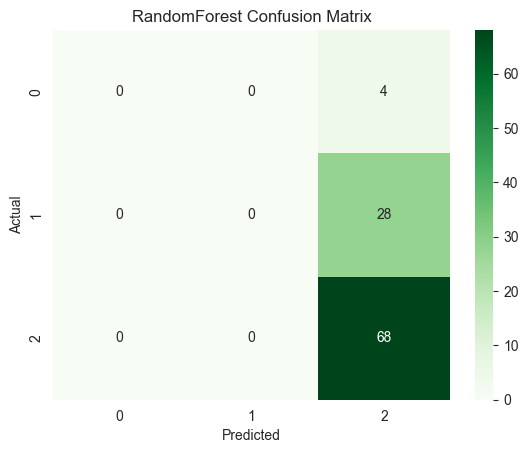

In [206]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('RandomForest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [207]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred, average='macro')
print("Macro-Averaged F1 Score:", f1)

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

class_labels = sorted(y_test.unique())

print("\nPrecision and Recall by Class:")
for i, label in enumerate(class_labels):
    print(f"Class {label}: Precision = {precision[i]:.3f}, Recall = {recall[i]:.3f}")

Macro-Averaged F1 Score: 0.2698412698412698

Precision and Recall by Class:
Class 0: Precision = 0.000, Recall = 0.000
Class 1: Precision = 0.000, Recall = 0.000
Class 2: Precision = 0.680, Recall = 1.000


/Users/Aysha/PycharmProjects/AI4ALL-Ignite-SU25/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [208]:
import joblib
joblib.dump(model, 'randomForest_model.pkl')

['randomForest_model.pkl']

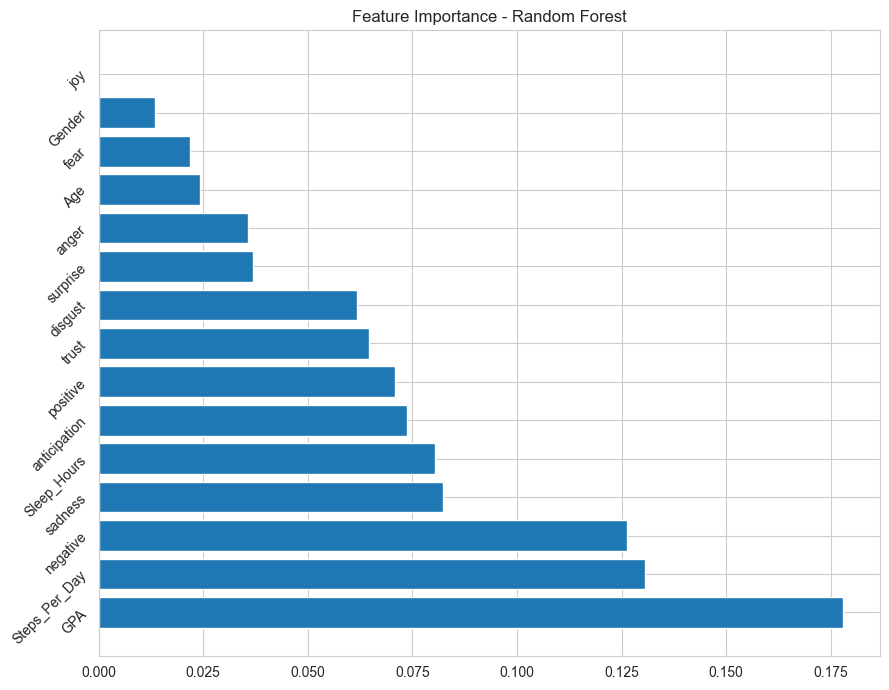

In [209]:
importances = model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(9, 7))
plt.title("Feature Importance - Random Forest")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.tight_layout()
plt.show()